In [2]:
import pandas as pd 
import numpy as np 
from scipy.optimize import root, LinearConstraint
import matplotlib.pyplot as plt 

from grid_model import GridModel, ORPDHandler #, GridDataClass
from grid_data_class import FileType, GridDataClass
import import_grid_model

In [3]:
grid_data = GridDataClass("grid_model_data//grid_data3.xlsx", FileType.Excel, f_nom=50, S_base_mva=100.0)
grid_model = GridModel(grid_data) 
# grid_data.change_P_gen([1], [400])
# grid_data.change_V_gen([1], [1.05])
V_init = np.array([1.0, 1.0])
opf = ORPDHandler(grid_model, [1, 2], I_lim_mat=grid_data.I_lims_pu.to_numpy())

In [4]:
opf.const(V_init) 
opf.get_ORPD_func()(V_init)

0.35950907768660567

In [5]:
sol = opf.solve_ORPD(V_init) 
print(sol.x)
opf.get_ORPD_func()(sol.x)

[1.00085933 1.00186909]


0.35922921945710584

In [6]:
sol = grid_model.powerflow() 
sol.get_sol_df() 

,P_inj MW,Q_inj_Mvar,V_bus_pu,delta_bus_deg
0,10.359229,1.625931,1.000000,0.000000
1,-50.000000,-20.000000,0.995227,-0.657711
2,40.000000,14.709439,1.000859,-0.178064
3,5.000000,7.100183,1.001869,-0.740613
4,-5.000000,-2.000000,0.951463,-2.479491


In [7]:
V_vals = sol.V_buses
delta_vals = sol.d_buses 
V_vec = V_vals*np.cos(delta_vals) + V_vals*np.sin(delta_vals)*1j
Y_lines = grid_data.get_Y_lines() 
I_mat = grid_model._get_I_mat(V_vec) 
S_mat = grid_model._get_S_mat(V_vals, delta_vals)

In [8]:
columns = [f"From {i}" for i in range(5)]
indices = [f"To {i}" for i in range(5)]
is_lim = (np.abs(I_mat) * (-np.eye(5) + 1) > grid_data.I_lims_pu)

I_mat_df = pd.DataFrame(np.abs(I_mat), columns=columns, index=indices)
I_lim_df = pd.DataFrame(np.abs(grid_data.I_lims_pu), columns=columns, index=indices)
I_const_df = pd.DataFrame(is_lim, columns=columns, index=indices)


In [9]:
I_mat_df

,From 0,From 1,From 2,From 3,From 4
To 0,0.000000,0.104861,0.000000,0.000000,0.000000
To 1,0.104861,0.002985,0.425823,0.045309,0.000000
To 2,0.000000,0.425823,0.000000,0.000000,0.000000
To 3,0.000000,0.045309,0.000000,0.003005,0.056599
To 4,0.000000,0.000000,0.000000,0.056599,0.000000


In [10]:
I_lim_df 

,From 0,From 1,From 2,From 3,From 4
To 0,0.000000,0.457261,0.000000,0.000000,0.000000
To 1,0.457261,0.000000,0.457261,0.200000,0.000000
To 2,0.000000,0.457261,0.000000,0.000000,0.000000
To 3,0.000000,0.200000,0.000000,0.000000,0.457261
To 4,0.000000,0.000000,0.000000,0.457261,0.000000


In [11]:
I_const_df


,From 0,From 1,From 2,From 3,From 4
To 0,False,False,False,False,False
To 1,False,False,False,False,False
To 2,False,False,False,False,False
To 3,False,False,False,False,False
To 4,False,False,False,False,False


In [12]:
ORPF_model = ORPDHandler(grid_model, np.array([1, 2]), I_lim_mat=grid_data.I_lims_pu.to_numpy())
sol = ORPF_model.solve_ORPD()
sol 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.35922921945710584
       x: [ 1.001e+00  1.002e+00]
     nit: 3
     jac: [ 1.718e-04  1.160e-04]
    nfev: 19
    njev: 3

In [13]:
ORPF_model.get_problem_dict()

{'fit_func': <function grid_model.ORPDHandler.get_ORPD_func.<locals>.ORPD(V_vals)>,
 'lb': [0.9, 0.9],
 'ub': [1.1, 1.1],
 'minmax': 'min',
 'log_to': 'console'}

In [14]:
V1_vals = np.linspace(0.95, 1.05, 50)
V2_vals = np.linspace(0.95, 1.05, 50)
V1_mesh, V2_mesh = np.meshgrid(V1_vals, V2_vals)

P_loss = np.zeros_like(V1_mesh)
is_inside = np.zeros_like(P_loss)
func = ORPF_model.get_ORPD_func()

for j, V1 in enumerate(V1_vals): 
    for i, V2 in enumerate(V2_vals): 
        ORPF_model.get_ORPD_func()
        P_loss[i, j] = func(np.array([V1, V2]))
        is_inside[i, j] = int(ORPF_model.is_inside_const(np.array([V1, V2])))
        

In [15]:
V_opt = ORPF_model.solve_ORPD(np.array([0.9, 1.1]))
V_opt 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.35922926796516474
       x: [ 1.001e+00  1.002e+00]
     nit: 6
     jac: [ 7.078e-03 -2.460e-03]
    nfev: 33
    njev: 6

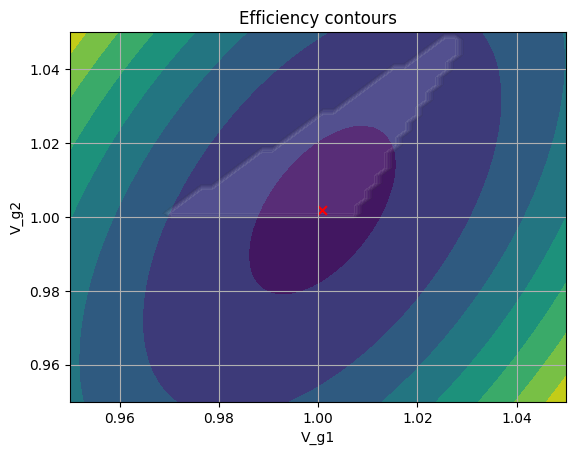

In [16]:
plt.contourf(V1_mesh, V2_mesh, P_loss) 
plt.contourf(V1_mesh, V2_mesh, is_inside, alpha=0.1, cmap="gist_gray")
plt.scatter([V_opt.x[0]], [V_opt.x[1]], s=40, color="red", marker="x")
plt.grid() 
plt.xlabel("V_g1")
plt.ylabel("V_g2")
plt.title("Efficiency contours")

plt.show() 

In [14]:
N_1 = 20 
N_2 = 20
P_load_1 = np.linspace(0.0, 30.0, N_1)
P_load_2 = np.linspace(0.0, 30.0, N_2)
P1_mesh, P2_mesh = np.meshgrid(P_load_1, P_load_2)
grid_data.change_Q_load([0, 1], [0, 0])

P_loss = np.zeros((N_1, N_2))
V1_opt = np.zeros((N_1, N_2))
V2_opt = np.zeros((N_1, N_2))

for j, P1 in enumerate(P_load_1): 
    for i, P2 in enumerate(P_load_2): 
        grid_data.change_P_load([0, 1], [P1, P2])
        sol = ORPF_model.solve_ORPD()
        P_loss[i, j] = sol.fun 
        V1_opt[i, j] = sol.x[0]
        V2_opt[i, j] = sol.x[1]        

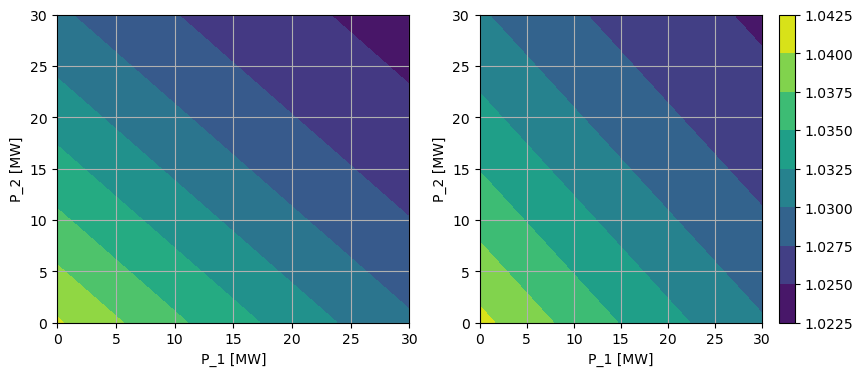

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
CS = ax[0].contourf(P1_mesh, P2_mesh, V1_opt) 
CS = ax[1].contourf(P1_mesh, P2_mesh, V2_opt) 
cbar = fig.colorbar(CS)

ax[0].set_xlabel("P_1 [MW]")
ax[0].set_ylabel("P_2 [MW]")
ax[0].grid()
ax[1].set_xlabel("P_1 [MW]")
ax[1].set_ylabel("P_2 [MW]")
ax[1].grid()
plt.show() 

In [5]:
from mealpy.swarm_based import PSO

func = ORPF_model.get_ORPD_func()
problem_dict = ORPF_model.get_problem_dict()

# ga_model = GA.BaseGA(epoch=50, pop_size=100, pc=0.85, pm=0.1)
ga_model = PSO.OriginalPSO(epoch=50, pop_size=500)
best_position, best_fitness_value = ga_model.solve(problem_dict, mode="single", n_workers=8)

print(best_position)
print(best_fitness_value)

2023/03/06 12:07:59 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.
2023/03/06 12:07:59 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 1, Current best: 0.8582742459566752, Global best: 0.8582742459566752, Runtime: 0.35898 seconds
2023/03/06 12:08:00 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 2, Current best: 0.8582742459566752, Global best: 0.8582742459566752, Runtime: 0.41387 seconds
2023/03/06 12:08:00 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 3, Current best: 0.8582742459566752, Global best: 0.8582742459566752, Runtime: 0.35962 seconds
2023/03/06 12:08:00 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 4, Current best: 0.8582742459566752, Global best: 0.8582742459566752, Runtime: 0.36283 seconds
2023/03/06 12:08:01 PM, INFO, mealpy.swarm_based.PSO.OriginalPSO: >Problem: P, Epoch: 5, Current best: 0.8582742459566752, Global best: 0.8582742459566752, Runtime

[1.03007426 1.02936883]
0.8576799099874322


In [12]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.8576798644073058
       x: [ 1.030e+00  1.029e+00]
     nit: 4
     jac: [-1.834e-02 -1.707e-03]
    nfev: 16
    njev: 4

In [1]:
from import_grid_model import get_item_dict 
bus_data, branch_data = get_item_dict(filename="grid_model_data//IEEE 30-bus RAW.txt")

In [2]:
bus_data[0]

{'bus_num': 1,
 'name': 'Glen Lyn 132',
 'area': 1,
 'loss_zone': 1,
 'type': 3,
 'final_v': 1.06,
 'final_delta': 0.0,
 'load_mw': 0.0,
 'load_mvar': 0.0,
 'gen_mw': 260.2,
 'gen_mvar': -16.1,
 'base_kV': 132.0,
 'v_desire': 0.06,
 'q_max': 0.0,
 'q_min': 0.0,
 'shunt_g_pu': 0.0,
 'shunt_b_pu': 0.0,
 'remote_bus': 0}

In [166]:
bus_locs = {"bus_num": (1, 5), "name": (5, 19), "area": (19, 21), "loss_zone": (21, 24), "type": (25, 27), 
            "final_v": (27, 33), "final_delta": (34, 41), "load_mw": (41, 50), "load_mvar": (50, 60), "gen_mw": (60, 68), "gen_mvar": (68, 75), 
            "base_kV": (77, 84), "v_desire": (85, 91), "q_max": (91, 99), "q_min": (99, 106), "shunt_g_pu": (107, 115), "shunt_b_pu": (115, 123), 
            "remote_bus": (124, 128)}
bus_types = {"bus_num": int, "name": str, "area": int, "loss_zone": int, "type": int, 
            "final_v": float, "final_delta": float, "load_mw": float, "load_mvar": float, "gen_mw": float, "gen_mvar": float, 
            "base_kV": float, "v_desire": float, "q_max": float, "q_min": float, "shunt_g_pu": float, "shunt_b_pu": float, 
            "remote_bus": int}

branch_locs = {"tap_bus": (1, 5), "Z_bus": (6,9), "area": (10, 13), "loss_zone": (13, 15), "circuit": (16, 18), "type": (18, 21), 
               "r_pu": (20, 29), "x_pu": (30, 40), "b_pu": (41, 50), "line_MVA_1": (51, 55), "line_MVA_2": (57, 61), "line_MVA_3": (63, 67), 
               "control_bus": (69, 72), "side": (73, 75), "tap_ratio_final": (77, 82), "phase_shift": (84, 90), "tap_min": (90, 97), "tap_max": (98, 104), 
               "step_size": (106, 111), "min_V/MVA": (112, 117), "max_V/MVA": (119, 125)}
branch_types = {"tap_bus": int, "Z_bus": int, "area": int, "loss_zone": int, "circuit": int, "type": int, 
               "r_pu": float, "x_pu": float, "b_pu": float, "line_MVA_1": float, "line_MVA_2": float, "line_MVA_3": float, 
               "control_bus": int, "side": int, "tap_ratio_final": float, "phase_shift": float, "tap_min": float, "tap_max": float, 
               "step_size": float, "min_V/MVA": float, "max_V/MVA": float}

def get_vals(data_row, data_locs, data_types): 
    data = {}
    for (name, val), (_, dtype) in zip(data_locs.items(), data_types.items()): 
        # print(val, name) 
        str_val = dtype(data_row[val[0] : val[1]].strip())
        print(str_val, name)
        data[name] = str_val
    return data



In [167]:

idx_bus_start = 2
with open("grid_model_data//IEEE 30-bus RAW.txt") as f: 
    lines = [line.rstrip() for line in f]

date_line = lines[0]
bus_data_info = lines[1]
N_buses = int(bus_data_info[-14:].strip()[:-6]) # Experimental 

bus_data = []
for i, line in enumerate(lines[2:N_buses+2]):
    bus_data.append(get_vals(line, bus_locs, bus_types))

idx = N_buses + 2 + 1 
branch_data_info = lines[idx]
N_branches = int(branch_data_info[-14:].strip()[:-6]) # Experimental 

branch_data = []
for i, branch in enumerate(lines[idx+1 : idx+1+N_branches]):
    branch_data.append(get_vals(branch, branch_locs, branch_types))


1 bus_num
Glen Lyn 132 name
1 area
1 loss_zone
3 type
1.06 final_v
0.0 final_delta
0.0 load_mw
0.0 load_mvar
260.2 gen_mw
-16.1 gen_mvar
132.0 base_kV
0.06 v_desire
0.0 q_max
0.0 q_min
0.0 shunt_g_pu
0.0 shunt_b_pu
0 remote_bus
2 bus_num
Claytor  132 name
1 area
1 loss_zone
2 type
1.043 final_v
-5.48 final_delta
21.7 load_mw
12.7 load_mvar
40.0 gen_mw
50.0 gen_mvar
132.0 base_kV
0.045 v_desire
50.0 q_max
-40.0 q_min
0.0 shunt_g_pu
0.0 shunt_b_pu
0 remote_bus
3 bus_num
Kumis    132 name
1 area
1 loss_zone
0 type
1.021 final_v
-7.96 final_delta
2.4 load_mw
1.2 load_mvar
0.0 gen_mw
0.0 gen_mvar
132.0 base_kV
0.0 v_desire
0.0 q_max
0.0 q_min
0.0 shunt_g_pu
0.0 shunt_b_pu
0 remote_bus
4 bus_num
Hancock  132 name
1 area
1 loss_zone
0 type
1.012 final_v
-9.62 final_delta
7.6 load_mw
1.6 load_mvar
0.0 gen_mw
0.0 gen_mvar
132.0 base_kV
0.0 v_desire
0.0 q_max
0.0 q_min
0.0 shunt_g_pu
0.0 shunt_b_pu
0 remote_bus
5 bus_num
Fieldale 132 name
1 area
1 loss_zone
2 type
1.01 final_v
14.37 final_delta


In [169]:
branch_data[-6]

{'tap_bus': 28,
 'Z_bus': 27,
 'area': 1,
 'loss_zone': 1,
 'circuit': 1,
 'type': 0,
 'r_pu': 0.0,
 'x_pu': 0.396,
 'b_pu': 0.0,
 'line_MVA_1': 0.0,
 'line_MVA_2': 0.0,
 'line_MVA_3': 0.0,
 'control_bus': 0,
 'side': 0,
 'tap_ratio_final': 0.968,
 'phase_shift': 0.0,
 'tap_min': 0.0,
 'tap_max': 0.0,
 'step_size': 0.0,
 'min_V/MVA': 0.0,
 'max_V/MVA': 0.0}

In [115]:
lines 

[' 08/20/93 UW ARCHIVE           100.0  1961 W IEEE 30 Bus Test Case',
 'BUS DATA FOLLOWS                            30 ITEMS',
 '   1 Glen Lyn 132  1  1  3 1.060    0.0      0.0      0.0    260.2   -16.1   132.0  1.060     0.0     0.0   0.0    0.0        0',
 '   2 Claytor  132  1  1  2 1.043  -5.48     21.7     12.7     40.0    50.0   132.0  1.045    50.0   -40.0   0.0    0.0        0',
 '   3 Kumis    132  1  1  0 1.021  -7.96      2.4      1.2      0.0     0.0   132.0  0.0       0.0     0.0   0.0    0.0        0',
 '   4 Hancock  132  1  1  0 1.012  -9.62      7.6      1.6      0.0     0.0   132.0  0.0       0.0     0.0   0.0    0.0        0',
 '   5 Fieldale 132  1  1  2 1.010 -14.37     94.2     19.0      0.0    37.0   132.0  1.010    40.0   -40.0   0.0    0.0        0',
 '   6 Roanoke  132  1  1  0 1.010 -11.34      0.0      0.0      0.0     0.0   132.0  0.0       0.0     0.0   0.0    0.0        0',
 '   7 Blaine   132  1  1  0 1.002 -13.12     22.8     10.9      0.0     0.0   1

In [66]:
val[1]

128

In [79]:
"hello lolo lo       ".strip()

'hello lolo lo'

In [23]:
def fun(X): 
    return X, 2*X 

f1, f2 =  (lambda X: fun(X)[0], lambda X: fun(X)[1])

In [27]:
f1(1)

1

In [28]:
np.concatenate((np.array([0,1,2,3,4]), np.array([0,1,2,3,4])))

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])